# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

## Analytic methods

If we know the parameters of the sampling distribution, we can compute confidence intervals and p-values analytically, which is computationally faster than resampling.

In [2]:
import scipy.stats

def EvalNormalCdfInverse(p, mu=0, sigma=1):
    return scipy.stats.norm.ppf(p, loc=mu, scale=sigma)

Here's the confidence interval for the estimated mean.

In [3]:
EvalNormalCdfInverse(0.05, mu=90, sigma=2.5)

85.887865932621324

In [4]:
EvalNormalCdfInverse(0.95, mu=90, sigma=2.5)

94.112134067378676

`normal.py` provides a `Normal` class that encapsulates what we know about arithmetic operations on normal distributions.

In [5]:
from normal import Normal

dist = Normal(90, 7.5**2)
dist

Normal(90, 56.25)

We can use it to compute the sampling distribution of the mean.

In [6]:
dist_xbar = dist.Sum(9) / 9
dist_xbar.sigma

2.5

And then compute a confidence interval.

In [7]:
dist_xbar.Percentile(5), dist_xbar.Percentile(95)

(85.887865932621324, 94.112134067378676)

## Central Limit Theorem

If you add up independent variates from a distribution with finite mean and variance, the sum converges on a normal distribution.

The following function generates samples with difference sizes from an exponential distribution.

In [8]:
def MakeExpoSamples(beta=2.0, iters=1000):
    """Generates samples from an exponential distribution.

    beta: parameter
    iters: number of samples to generate for each size

    returns: list of samples
    """
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.exponential(beta, n))
                  for _ in range(iters)]
        samples.append((n, sample))
    return samples

This function generates normal probability plots for samples with various sizes.

In [9]:
def NormalPlotSamples(samples, plot=1, ylabel=''):
    """Makes normal probability plots for samples.

    samples: list of samples
    label: string
    """
    for n, sample in samples:
        thinkplot.SubPlot(plot)
        thinkstats2.NormalProbabilityPlot(sample)

        thinkplot.Config(title='n=%d' % n,
                         legend=False,
                         xticks=[],
                         yticks=[],
                         xlabel='random normal variate',
                         ylabel=ylabel)
        plot += 1

The following plot shows how the sum of exponential variates converges to normal as sample size increases.

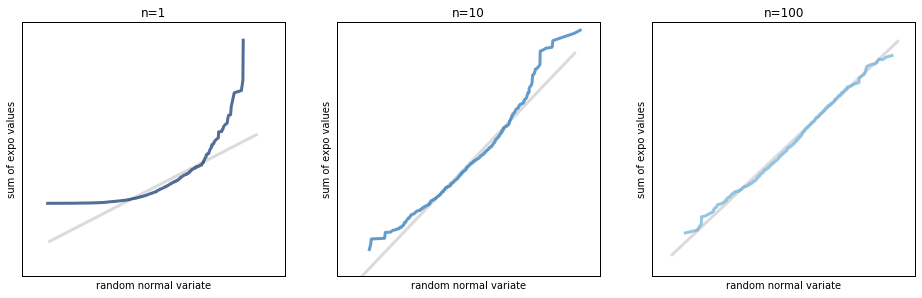

In [10]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeExpoSamples()
NormalPlotSamples(samples, plot=1,
                  ylabel='sum of expo values')

The lognormal distribution has higher variance, so it requires a larger sample size before it converges to normal.

In [11]:
def MakeLognormalSamples(mu=1.0, sigma=1.0, iters=1000):
    """Generates samples from a lognormal distribution.

    mu: parmeter
    sigma: parameter
    iters: number of samples to generate for each size

    returns: list of samples
    """
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.lognormal(mu, sigma, n))
                  for _ in range(iters)]
        samples.append((n, sample))
    return samples

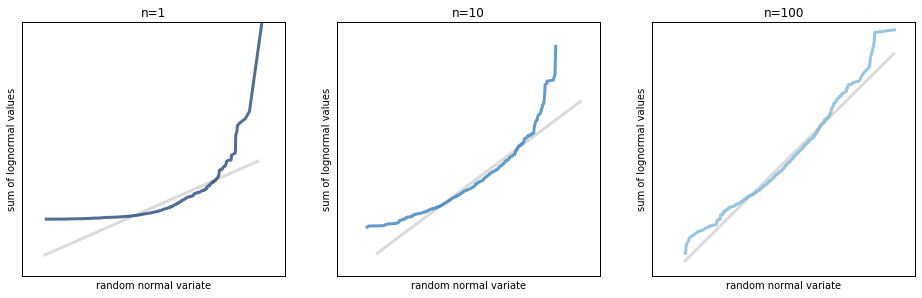

In [12]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeLognormalSamples()
NormalPlotSamples(samples, ylabel='sum of lognormal values')

The Pareto distribution has infinite variance, and sometimes infinite mean, depending on the parameters.  It violates the requirements of the CLT and does not generally converge to normal.

In [13]:
def MakeParetoSamples(alpha=1.0, iters=1000):
    """Generates samples from a Pareto distribution.

    alpha: parameter
    iters: number of samples to generate for each size

    returns: list of samples
    """
    samples = []

    for n in [1, 10, 100]:
        sample = [np.sum(np.random.pareto(alpha, n))
                  for _ in range(iters)]
        samples.append((n, sample))
    return samples

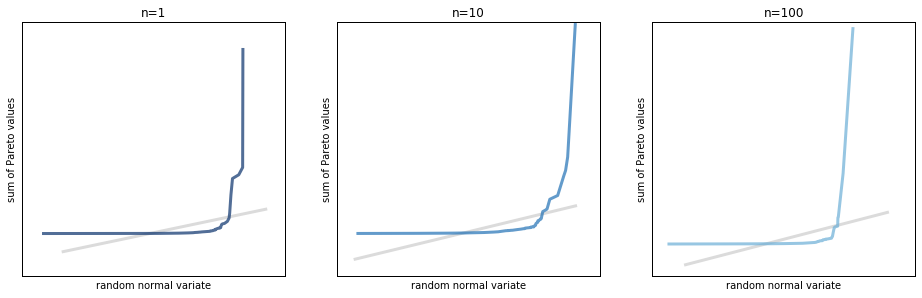

In [14]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeParetoSamples()
NormalPlotSamples(samples, ylabel='sum of Pareto values')

If the random variates are correlated, that also violates the CLT, so the sums don't generally converge.

To generate correlated values, we generate correlated normal values and then transform to whatever distribution we want.

In [15]:
def GenerateCorrelated(rho, n):
    """Generates a sequence of correlated values from a standard normal dist.
    
    rho: coefficient of correlation
    n: length of sequence

    returns: iterator
    """
    x = random.gauss(0, 1)
    yield x

    sigma = np.sqrt(1 - rho**2)
    for _ in range(n-1):
        x = random.gauss(x * rho, sigma)
        yield x

In [16]:
def GenerateExpoCorrelated(rho, n):
    """Generates a sequence of correlated values from an exponential dist.

    rho: coefficient of correlation
    n: length of sequence

    returns: NumPy array
    """
    normal = list(GenerateCorrelated(rho, n))
    uniform = scipy.stats.norm.cdf(normal)
    expo = scipy.stats.expon.ppf(uniform)
    return expo

In [17]:
def MakeCorrelatedSamples(rho=0.9, iters=1000):
    """Generates samples from a correlated exponential distribution.

    rho: correlation
    iters: number of samples to generate for each size

    returns: list of samples
    """    
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(GenerateExpoCorrelated(rho, n))
                  for _ in range(iters)]
        samples.append((n, sample))
    return samples


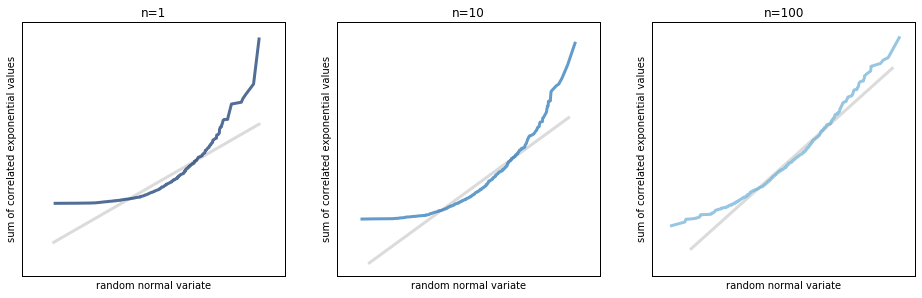

In [18]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeCorrelatedSamples()
NormalPlotSamples(samples, ylabel='sum of correlated exponential values')

## Difference in means

Let's use analytic methods to compute a CI and p-value for an observed difference in means.

The distribution of pregnancy length is not normal, but it has finite mean and variance, so the sum (or mean) of a few thousand samples is very close to normal.

In [19]:
import first

live, firsts, others = first.MakeFrames()
delta = firsts.prglngth.mean() - others.prglngth.mean()
delta

0.07803726677754952

The following function computes the sampling distribution of the mean for a set of values and a given sample size.

In [20]:
def SamplingDistMean(data, n):
    """Computes the sampling distribution of the mean.

    data: sequence of values representing the population
    n: sample size

    returns: Normal object
    """
    mean, var = data.mean(), data.var()
    dist = Normal(mean, var)
    return dist.Sum(n) / n

Here are the sampling distributions for the means of the two groups under the null hypothesis.

In [21]:
dist1 = SamplingDistMean(live.prglngth, len(firsts))
dist2 = SamplingDistMean(live.prglngth, len(others))

And the sampling distribution for the difference in means.

In [22]:
dist_diff = dist1 - dist2
dist

Normal(90, 56.25)

Under the null hypothesis, here's the chance of exceeding the observed difference.

In [23]:
1 - dist_diff.Prob(delta)

0.083770704255438311

And the chance of falling below the negated difference.

In [24]:
dist_diff.Prob(-delta)

0.083770704255438255

The sum of these probabilities is the two-sided p-value.

## Testing a correlation

Under the null hypothesis (that there is no correlation), the sampling distribution of the observed correlation (suitably transformed) is a "Student t" distribution.

In [25]:
def StudentCdf(n):
    """Computes the CDF correlations from uncorrelated variables.

    n: sample size

    returns: Cdf
    """
    ts = np.linspace(-3, 3, 101)
    ps = scipy.stats.t.cdf(ts, df=n-2)
    rs = ts / np.sqrt(n - 2 + ts**2)
    return thinkstats2.Cdf(rs, ps)

The following is a `HypothesisTest` that uses permutation to estimate the sampling distribution of a correlation. 

In [26]:
import hypothesis

class CorrelationPermute(hypothesis.CorrelationPermute):
    """Tests correlations by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: tuple of xs and ys
        """
        xs, ys = data
        return np.corrcoef(xs, ys)[0][1]

Now we can estimate the sampling distribution by permutation and compare it to the Student t distribution.

In [27]:
def ResampleCorrelations(live):
    """Tests the correlation between birth weight and mother's age.

    live: DataFrame for live births

    returns: sample size, observed correlation, CDF of resampled correlations
    """
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p_value = ht.PValue()
    return len(live2), ht.actual, ht.test_cdf

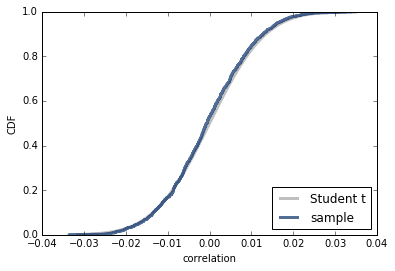

In [28]:
n, r, cdf = ResampleCorrelations(live)

model = StudentCdf(n)
thinkplot.Plot(model.xs, model.ps, color='gray',
               alpha=0.5, label='Student t')
thinkplot.Cdf(cdf, label='sample')

thinkplot.Config(xlabel='correlation',
                 ylabel='CDF',
                 legend=True, loc='lower right')

That confirms the analytic result.  Now we can use the CDF of the Student t distribution to compute a p-value.

In [29]:
t = r * np.sqrt((n-2) / (1-r**2))
p_value = 1 - scipy.stats.t.cdf(t, df=n-2)
print(r, p_value)

0.0688339703541 2.86146661921e-11


##  Chi-squared test

The reason the chi-squared statistic is useful is that we can compute its distribution under the null hypothesis analytically.

In [30]:
def ChiSquaredCdf(n):
    """Discrete approximation of the chi-squared CDF with df=n-1.

    n: sample size
    
    returns: Cdf
    """
    xs = np.linspace(0, 25, 101)
    ps = scipy.stats.chi2.cdf(xs, df=n-1)
    return thinkstats2.Cdf(xs, ps)

Again, we can confirm the analytic result by comparing values generated by simulation with the analytic distribution.

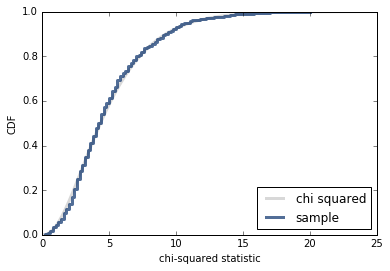

In [31]:
data = [8, 9, 19, 5, 8, 11]
dt = hypothesis.DiceChiTest(data)
p_value = dt.PValue(iters=1000)
n, chi2, cdf = len(data), dt.actual, dt.test_cdf

model = ChiSquaredCdf(n)
thinkplot.Plot(model.xs, model.ps, color='gray',
                   alpha=0.3, label='chi squared')
thinkplot.Cdf(cdf, label='sample')

thinkplot.Config(xlabel='chi-squared statistic',
                 ylabel='CDF',
                 loc='lower right')

And then we can use the analytic distribution to compute p-values.

In [32]:
p_value = 1 - scipy.stats.chi2.cdf(chi2, df=n-1)
print(chi2, p_value)

11.6 0.040699388504


## Exercises

**Exercise:**    In Section 5.4, we saw that the distribution of adult weights is approximately lognormal. One possible explanation is that the weight a person gains each year is proportional to their current weight. In that case, adult weight is the product of a large number of multiplicative factors:

w = w0 f1 f2 ... fn  

where w is adult weight, w0 is birth weight, and fi is the weight gain factor for year i.

The log of a product is the sum of the logs of the factors:

logw = logw0 + logf1 + logf2 + ... + logfn 

So by the Central Limit Theorem, the distribution of logw is approximately normal for large n, which implies that the distribution of w is lognormal.

To model this phenomenon, choose a distribution for f that seems reasonable, then generate a sample of adult weights by choosing a random value from the distribution of birth weights, choosing a sequence of factors from the distribution of f, and computing the product. What value of n is needed to converge to a lognormal distribution?

In [33]:
# Solution

def GenerateAdultWeight(birth_weights, n):
    """Generate a random adult weight by simulating annual gain.

    birth_weights: sequence of birth weights in lbs
    n: number of years to simulate

    returns: adult weight in lbs
    """
    bw = random.choice(birth_weights)
    factors = np.random.normal(1.09, 0.03, n)
    aw = bw * np.prod(factors)
    return aw

In [34]:
# Solution

def PlotAdultWeights(live):
    """Makes a normal probability plot of log10 adult weight.

    live: DataFrame of live births

    
    """
    birth_weights = live.totalwgt_lb.dropna().values
    aws = [GenerateAdultWeight(birth_weights, 40) for _ in range(1000)]
    log_aws = np.log10(aws)
    thinkstats2.NormalProbabilityPlot(log_aws)
    thinkplot.Config(xlabel='standard normal values',
                     ylabel='adult weight (log10 lbs)',
                     loc='lower right')

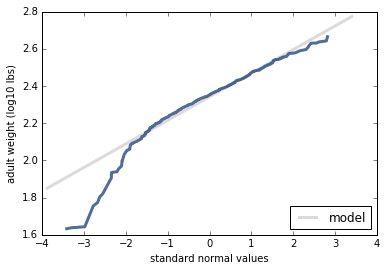

In [35]:
# Solution

PlotAdultWeights(live)

In [36]:
# Solution

# With n=40 the distribution is approximately lognormal except for the lowest weights.

# Actual distribution might deviate from lognormal because it is
# a mixture of people at different ages, or because annual weight
# gains are correlated.

**Exercise:** In Section 14.6 we used the Central Limit Theorem to find the sampling distribution of the difference in means, δ, under the null hypothesis that both samples are drawn from the same population.

We can also use this distribution to find the standard error of the estimate and confidence intervals, but that would only be approximately correct. To be more precise, we should compute the sampling distribution of δ under the alternate hypothesis that the samples are drawn from different populations.

Compute this distribution and use it to calculate the standard error and a 90% confidence interval for the difference in means.

In [37]:
# Solution

# Here's the observed difference in means

delta = firsts.prglngth.mean() - others.prglngth.mean()
print(delta)

0.0780372667775


In [38]:
# Solution

# Under the null hypothesis, both sampling distributions are based
# on all live births.

dist1 = SamplingDistMean(live.prglngth, len(firsts))
dist2 = SamplingDistMean(live.prglngth, len(others))
dist_diff_null = dist1 - dist2
print('null hypothesis', dist_diff_null)
print(dist_diff_null.Prob(-delta), 1 - dist_diff_null.Prob(delta))

null hypothesis Normal(0, 0.00319708)
0.0837707042554 0.0837707042554


In [39]:
# Solution

# Under the alternate hypothesis, each sampling distribution is
# based on the observed parameters.

dist1 = SamplingDistMean(firsts.prglngth, len(firsts))
dist2 = SamplingDistMean(others.prglngth, len(others))
dist_diff_alt = dist1 - dist2
print('estimated params', dist_diff_alt)
print(dist_diff_alt.Percentile(5), dist_diff_alt.Percentile(95))

estimated params Normal(0.0780373, 0.00321144)
-0.0151758158699 0.171250349425


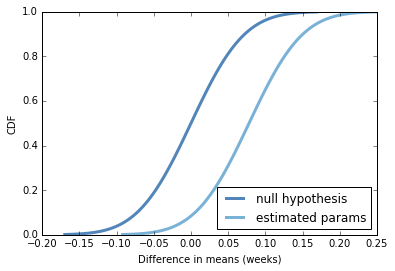

In [40]:
# Solution

# The distribution of the difference under the null hypothesis is
# centered at 0.

# The distribution of the difference using the estimated parameters
# is centered around the observed difference.

thinkplot.PrePlot(2)
thinkplot.Plot(dist_diff_null, label='null hypothesis')

thinkplot.Plot(dist_diff_alt, label='estimated params')
thinkplot.Config(xlabel='Difference in means (weeks)',
               ylabel='CDF', loc='lower right')

**Exercise:** [In a recent paper](http://ieeexplore.ieee.org/document/7044435/), Stein et al. investigate the effects of an intervention intended to mitigate gender-stereotypical task allocation within student engineering teams.

Before and after the intervention, students responded to a survey that asked them to rate their contribution to each aspect of class projects on a 7-point scale.

Before the intervention, male students reported higher scores for the programming aspect of the project than female students; on average men reported a score of 3.57 with standard error 0.28. Women reported 1.91, on average, with standard error 0.32.

Compute the sampling distribution of the gender gap (the difference in means), and test whether it is statistically significant. Because you are given standard errors for the estimated means, you don’t need to know the sample size to figure out the sampling distributions.

After the intervention, the gender gap was smaller: the average score for men was 3.44 (SE 0.16); the average score for women was 3.18 (SE 0.16). Again, compute the sampling distribution of the gender gap and test it.

Finally, estimate the change in gender gap; what is the sampling distribution of this change, and is it statistically significant?

In [41]:
# Solution

male_before = Normal(3.57, 0.28**2)
male_after = Normal(3.44, 0.16**2)

female_before = Normal(1.91, 0.32**2)
female_after = Normal(3.18, 0.16**2)

In [42]:
# Solution

diff_before = female_before - male_before
print('mean, p-value', diff_before.mu, 1-diff_before.Prob(0))
print('CI', diff_before.Percentile(5), diff_before.Percentile(95))
print('stderr', diff_before.sigma)

mean, p-value -1.66 4.73095323208e-05
CI -2.3594013558 -0.960598644196
stderr 0.425205832509


In [43]:
# Solution

diff_after = female_after - male_after
print('mean, p-value', diff_after.mu, 1-diff_after.Prob(0))
print('CI', diff_after.Percentile(5), diff_after.Percentile(95))
print('stderr', diff_after.sigma)

mean, p-value -0.26 0.125267987207
CI -0.632187889177 0.112187889177
stderr 0.22627416998


In [44]:
# Solution

diff = diff_after - diff_before
print('mean, p-value', diff.mu, diff.Prob(0))
print('CI', diff.Percentile(5), diff.Percentile(95))
print('stderr', diff.sigma)

mean, p-value 1.4 0.00182694836898
CI 0.607733579312 2.19226642069
stderr 0.481663783152


In [45]:
# Solution

# Conclusions:

# 1) Gender gap before intervention was 1.66 points (p-value 5e-5)

# 2) Genger gap after was 0.26 points (p-value 0.13, not significant)

# 3) Change in gender gap was 1.4 points (p-value 0.002, significant).